## **EXP2 Predicting Missing Cell-Types from Bulks using CIBERSORTx Residual**

*This file requieres pseudobulks to be processed and CIBERSORTx to be run.*

*See preprocessing/EXP2_pbmc_pseudos.ipynb and preprocessing/EXP2_ciber_bayes_prep.ipynb for details.**

**Summary:**
Increasing the number of missing celltypes, using random proportions pseudobulks. Then attempting to extract missing cell type information from residual. 

The residual is calculated in three different ways named: Residual (comparing CIBERSORTx calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from CIBERSORTx reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
CIBERSORTx

**Factorization Methods:**
NMF

In [ ]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import sklearn as sk
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

These parameters are set in EXP2.py file.

In [ ]:
#####################
### set the study ###
#####################
#these parameters are set in papermill 
res_name = "MCT_pbmc_EXP2"
pseudos_name = "MCT_pbmc_EXP1"
path = "/../data/"
aug_data_path = "/../data/EXP2/cibersort/selected_cells/"
data_path = "/../data/EXP1/"
cibersort_path = "/../data/EXP2/cibersort_results/selected_cells/"
num_missing_cells = [0,1,2,3,4]
nmf_cut = "minimum_value"
num_samples = 10000
path_results = "/../results/EXP2/"
data_type = "pbmc3k/"
noise_type = "nonoise"
prop_type = 'random'

In [ ]:
#Parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{path}"
aug_data_path = f"{actual_path}{aug_data_path}"
data_path = f"{actual_path}{data_path}"
cibersort_path = f"{actual_path}{cibersort_path}"
path_results = f"{actual_path}{path_results}"
bulk_type = f"{prop_type}prop_{noise_type}"

## Import the previously processed datasets. 

In [ ]:
pseudo_path = os.path.join(aug_data_path, f"{data_type}/{res_name}_{bulk_type}_mixture.txt")
pseudo_path = Path(pseudo_path)
# Open the file of mixture used
pseudo_df = pd.read_csv(pseudo_path, sep="\t")
#extracting gene_ids and setting as columns
pseudo_df.rename(columns = {'Unnamed: 0':'gene_ids'}, inplace = True)
gene_ids = pseudo_df["gene_ids"]
pseudo_df = pseudo_df.T
pseudo_df.columns = gene_ids
pseudo_df = pseudo_df.drop(labels = "gene_ids")
pseudo_df_copy = pseudo_df.copy()
pseudo_df

gene_ids AL627309.1 AP006222.2 RP11-206L10.2 RP11-206L10.9 LINC00115  NOC2L  \
0              19.0        8.0           6.0           7.0      34.0  582.0   
1               8.0        2.0           3.0           4.0      42.0  701.0   
2              20.0        8.0           3.0          11.0      51.0  578.0   
3              31.0        8.0           2.0          14.0      33.0  591.0   
4               9.0        0.0           3.0           8.0      55.0  648.0   
..              ...        ...           ...           ...       ...    ...   
995            23.0        4.0           4.0          14.0      54.0  613.0   
996             9.0        4.0           5.0           6.0      37.0  602.0   
997             9.0        9.0           4.0           9.0      37.0  578.0   
998             7.0        3.0          12.0           7.0      39.0  651.0   
999            18.0        5.0           4.0          10.0      45.0  529.0   

gene_ids KLHL17 PLEKHN1 RP11-54O7.17    HES4  ... MT-ND4L   MT-ND4  MT-ND5  \
0          12.0    15.0         15.0   923.0  ...   802.0  26434.0  4813.0   
1          19.0    16.0         11.0   982.0  ...   881.0  24704.0  4466.0   
2           8.0    23.0         13.0  1047.0  ...   781.0  25360.0  4773.0   
3          19.0    19.0          9.0  1081.0  ...   852.0  24709.0  4791.0   
4          13.0    13.0          2.0   600.0  ...   821.0  22967.0  3998.0   
..          ...     ...          ...     ...  ...     ...      ...     ...   
995        19.0     8.0         12.0  1757.0  ...   822.0  26167.0  5128.0   
996        18.0     8.0          7.0  1025.0  ...   869.0  27033.0  4868.0   
997        16.0    15.0          3.0   424.0  ...   819.0  24436.0  4199.0   
998        20.0    12.0          3.0   817.0  ...   798.0  24564.0  3830.0   
999        16.0    24.0          6.0   296.0  ...   893.0  21365.0  3824.0   

gene_ids MT-ND6   MT-CYB AC145212.1 AL592183.1 AL354822.1 PNRC2-1 SRSF10-1  
0         552.0  23069.0       34.0      628.0       29.0   198.0    122.0  
1         508.0  20935.0       23.0      699.0       28.0   217.0    143.0  
2         539.0  21418.0       44.0      577.0       28.0   222.0    134.0  
3         532.0  21917.0       34.0      621.0       19.0   188.0    109.0  
4         500.0  19232.0       33.0      679.0       16.0   190.0    105.0  
..          ...      ...        ...        ...        ...     ...      ...  
995       505.0  22174.0       52.0      614.0       36.0   191.0    137.0  
996       526.0  22346.0       39.0      703.0       26.0   243.0    178.0  
997       537.0  21359.0       30.0      661.0       12.0   198.0    113.0  
998       402.0  19331.0       29.0      790.0       23.0   183.0    125.0  
999       505.0  18578.0       27.0      620.0        8.0   142.0     59.0  

[1000 rows x 13714 columns]

In [ ]:
#and importing anndata object
adata_path = os.path.join(data_path, f"{pseudos_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata_copy = sn_adata.copy()
sn_adata

AnnData object with n_obs × n_vars = 2589 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'scpred_CellType', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_types_colors', 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
#QC
print(Counter(sn_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sn_adata.obs.cell_types.unique())
cell_order = sn_adata.obs.cell_types.unique()

Counter({'CD4 T': 1119, 'CD14 Monocytes': 448, 'B': 342, 'CD8 T': 328, 'FCGR3A Monocytes': 188, 'NK': 164})


## Making Cell Type Reference:

In [ ]:
# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw.index = gene_ids.index

In [ ]:
#clipping before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df.index = gene_ids.index
ref_df_copy = ref_df.copy()

## **Reading In and QCing the CIBERSORTx Results:**

CIBERSORTx Results:

In [ ]:
#import all CIBERSORTx results and real proportions
cibersort_prop = dict()
real_prop_reb = dict()
real_prop = dict()
ref_cibersort = dict()
for num in num_missing_cells:
    #import cibersort proportions
    cibersort_results_path = os.path.join(cibersort_path, f"{data_type}/{num}_missing/CIBERSORTx_Results.txt")
    cibersort_results_path = Path(cibersort_results_path)
    # Open the CSV file in read mode
    cibersort_prop[num] = pd.read_csv(cibersort_results_path, sep="\t")
    cibersort_prop[num] = cibersort_prop[num].drop(labels = ["Mixture", "P-value", "Correlation", "RMSE"], axis = 1)
    cibersort_prop[num]

    #real proportions
    realprop_results_path = os.path.join(aug_data_path, f"{data_type}/{res_name}_{num}missing_{bulk_type}_prop.csv")
    realprop_results_path = Path(realprop_results_path)
    # Open the CSV file in read mode
    real_prop[num] = pd.read_csv(realprop_results_path, sep=",")

    #real rebalanced proportions
    real_prop_reb[num] = real_prop[num] 

    #and the reference used in cibersort
    ref_results_path = os.path.join(cibersort_path, f"{data_type}/{num}_missing/CIBERSORTx_{res_name}_{bulk_type}_{num}missing_signal_inferred_phenoclasses.CIBERSORTx_{res_name}_{bulk_type}_{num}missing_signal_inferred_refsample.bm.K999.txt")
    ref_results_path = Path(ref_results_path)
    # Open the CSV file in read mode
    ref_cibersort[num] = pd.read_csv(ref_results_path, sep="\t")
    ref_cibersort[num] = ref_cibersort[num].rename(columns = {'NAME':'gene_ids'})
    ref_cibersort[num].index = ref_cibersort[num]["gene_ids"]
    gene_ids[num] = ref_cibersort[num].index
    ref_cibersort[num] = ref_cibersort[num].drop(labels= "gene_ids", axis = 1)


/projects/aivich@xsede.org/code-server/tmp/ipykernel_1674828/4004390523.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_ids[num] = ref_cibersort[num].index


In [ ]:
#matching genes in reference, pseudobulks in gene_ids[num]
sn_adata = dict()
ref_df = dict()
gene_ids = dict()
#copying pseudobulks
pseudo_df_copy = pseudo_df.copy()
pseudo_df = dict()
for num in num_missing_cells:
    #cutting to gene_ids in reference
    pseudo_df[num] = pseudo_df_copy.copy()
    gene_ids[num] = pseudo_df[num].columns
    sn_adata[num] = sn_adata_copy[:, gene_ids[num]]
    ref_df[num] = ref_df_copy.loc[gene_ids[num], :]
    print(gene_ids[num].shape)
    #and  deleting missing cells form reference
    ref_df[num] = ref_df[num].filter(ref_cibersort[num].columns)

(13714,)
(13714,)
(13714,)
(13714,)
(13714,)


In [ ]:
#using rebalanced proportions (summing to one) after deleting cell types
real_prop = real_prop_reb

QC imported files:

In [ ]:
cibersort_prop[0]

CD8 T         B     CD4 T  FCGR3A Monocytes        NK  CD14 Monocytes
0    0.260867  0.084106  0.109972          0.308352  0.072814        0.163889
1    0.139487  0.099854  0.124524          0.340668  0.262156        0.033312
2    0.089663  0.061992  0.196743          0.332877  0.100703        0.218022
3    0.142050  0.041674  0.057017          0.324341  0.138373        0.296544
4    0.078919  0.121714  0.133163          0.197926  0.309841        0.158438
..        ...       ...       ...               ...       ...             ...
995  0.060257  0.073991  0.020310          0.504959  0.069425        0.271058
996  0.080016  0.049439  0.445240          0.358137  0.011795        0.055373
997  0.233915  0.085106  0.273593          0.155899  0.126692        0.124796
998  0.062715  0.405641  0.040802          0.287923  0.144775        0.058144
999  0.047328  0.048102  0.130151          0.062458  0.356101        0.355860

[1000 rows x 6 columns]

In [ ]:
real_prop[0]

CD8 T       B   CD4 T  FCGR3A Monocytes      NK  CD14 Monocytes
0    0.3200  0.0964  0.1202            0.1966  0.0890          0.1778
1    0.1680  0.1220  0.1248            0.2252  0.3254          0.0346
2    0.0980  0.0770  0.2296            0.2202  0.1296          0.2456
3    0.1890  0.0474  0.0418            0.2210  0.1826          0.3182
4    0.0666  0.1368  0.1512            0.1152  0.3702          0.1600
..      ...     ...     ...               ...     ...             ...
995  0.0806  0.1074  0.0076            0.3762  0.0988          0.3294
996  0.0804  0.0580  0.5474            0.2348  0.0176          0.0618
997  0.2642  0.0908  0.2782            0.0868  0.1510          0.1290
998  0.0524  0.5086  0.0306            0.1688  0.1762          0.0634
999  0.0388  0.0442  0.1342            0.0326  0.4104          0.3398

[1000 rows x 6 columns]

In [ ]:
real_prop[0]

CD8 T       B   CD4 T  FCGR3A Monocytes      NK  CD14 Monocytes
0    0.3200  0.0964  0.1202            0.1966  0.0890          0.1778
1    0.1680  0.1220  0.1248            0.2252  0.3254          0.0346
2    0.0980  0.0770  0.2296            0.2202  0.1296          0.2456
3    0.1890  0.0474  0.0418            0.2210  0.1826          0.3182
4    0.0666  0.1368  0.1512            0.1152  0.3702          0.1600
..      ...     ...     ...               ...     ...             ...
995  0.0806  0.1074  0.0076            0.3762  0.0988          0.3294
996  0.0804  0.0580  0.5474            0.2348  0.0176          0.0618
997  0.2642  0.0908  0.2782            0.0868  0.1510          0.1290
998  0.0524  0.5086  0.0306            0.1688  0.1762          0.0634
999  0.0388  0.0442  0.1342            0.0326  0.4104          0.3398

[1000 rows x 6 columns]

In [ ]:
ref_cibersort[0]

CD8 T           B       CD4 T  FCGR3A Monocytes          NK  \
gene_ids                                                                     
AAK1      115.281707    1.000000  126.822747          1.000000  108.127718   
AAMP        1.000000  145.506370    1.000000         65.961735    1.000000   
AATF        1.000000    1.000000    1.000000         67.724959  118.550772   
ABHD14A   107.149548    1.000000    1.000000          1.000000  101.949909   
ABHD14B   126.792633    1.000000  125.104192          1.000000  118.881993   
...              ...         ...         ...               ...         ...   
ZNF703      1.000000    1.000000    1.000000         86.703939    1.000000   
ZNRD1     107.546819    1.000000    1.000000          1.000000    1.000000   
ZRANB2      1.000000  106.932381    1.000000          1.000000    1.000000   
ZSWIM7      1.000000    1.000000    1.000000         75.138637    1.000000   
ZYX         1.000000    1.000000    1.000000        159.662111    1.000000   

          CD14 Monocytes  
gene_ids                  
AAK1            1.000000  
AAMP            1.000000  
AATF            1.000000  
ABHD14A         1.000000  
ABHD14B         1.000000  
...                  ...  
ZNF703          1.000000  
ZNRD1          89.771078  
ZRANB2          1.000000  
ZSWIM7         88.789539  
ZYX           164.355400  

[1338 rows x 6 columns]

In [ ]:
pseudo_df[0]

gene_ids AL627309.1 AP006222.2 RP11-206L10.2 RP11-206L10.9 LINC00115  NOC2L  \
0              19.0        8.0           6.0           7.0      34.0  582.0   
1               8.0        2.0           3.0           4.0      42.0  701.0   
2              20.0        8.0           3.0          11.0      51.0  578.0   
3              31.0        8.0           2.0          14.0      33.0  591.0   
4               9.0        0.0           3.0           8.0      55.0  648.0   
..              ...        ...           ...           ...       ...    ...   
995            23.0        4.0           4.0          14.0      54.0  613.0   
996             9.0        4.0           5.0           6.0      37.0  602.0   
997             9.0        9.0           4.0           9.0      37.0  578.0   
998             7.0        3.0          12.0           7.0      39.0  651.0   
999            18.0        5.0           4.0          10.0      45.0  529.0   

gene_ids KLHL17 PLEKHN1 RP11-54O7.17    HES4  ... MT-ND4L   MT-ND4  MT-ND5  \
0          12.0    15.0         15.0   923.0  ...   802.0  26434.0  4813.0   
1          19.0    16.0         11.0   982.0  ...   881.0  24704.0  4466.0   
2           8.0    23.0         13.0  1047.0  ...   781.0  25360.0  4773.0   
3          19.0    19.0          9.0  1081.0  ...   852.0  24709.0  4791.0   
4          13.0    13.0          2.0   600.0  ...   821.0  22967.0  3998.0   
..          ...     ...          ...     ...  ...     ...      ...     ...   
995        19.0     8.0         12.0  1757.0  ...   822.0  26167.0  5128.0   
996        18.0     8.0          7.0  1025.0  ...   869.0  27033.0  4868.0   
997        16.0    15.0          3.0   424.0  ...   819.0  24436.0  4199.0   
998        20.0    12.0          3.0   817.0  ...   798.0  24564.0  3830.0   
999        16.0    24.0          6.0   296.0  ...   893.0  21365.0  3824.0   

gene_ids MT-ND6   MT-CYB AC145212.1 AL592183.1 AL354822.1 PNRC2-1 SRSF10-1  
0         552.0  23069.0       34.0      628.0       29.0   198.0    122.0  
1         508.0  20935.0       23.0      699.0       28.0   217.0    143.0  
2         539.0  21418.0       44.0      577.0       28.0   222.0    134.0  
3         532.0  21917.0       34.0      621.0       19.0   188.0    109.0  
4         500.0  19232.0       33.0      679.0       16.0   190.0    105.0  
..          ...      ...        ...        ...        ...     ...      ...  
995       505.0  22174.0       52.0      614.0       36.0   191.0    137.0  
996       526.0  22346.0       39.0      703.0       26.0   243.0    178.0  
997       537.0  21359.0       30.0      661.0       12.0   198.0    113.0  
998       402.0  19331.0       29.0      790.0       23.0   183.0    125.0  
999       505.0  18578.0       27.0      620.0        8.0   142.0     59.0  

[1000 rows x 13714 columns]

In [ ]:
ref_df[0]

CD8 T         B     CD4 T  FCGR3A Monocytes        NK  \
gene_ids                                                                  
AL627309.1     0.010329  0.000000  0.004767          0.000000  0.000000   
AP006222.2     0.009535  0.000000  0.001589          0.000000  0.000000   
RP11-206L10.2  0.000000  0.013507  0.001059          0.000000  0.000000   
RP11-206L10.9  0.000000  0.000000  0.000000          0.012978  0.000000   
LINC00115      0.006886  0.020129  0.014832          0.027280  0.031517   
...                 ...       ...       ...               ...       ...   
AC145212.1     0.009005  0.014832  0.007416          0.031252  0.000000   
AL592183.1     0.279683  0.462696  0.380592          0.345896  0.395953   
AL354822.1     0.000000  0.015097  0.006356          0.047408  0.000000   
PNRC2-1        0.146463  0.078661  0.130307          0.109384  0.075748   
SRSF10-1       0.061181  0.080250  0.085547          0.139312  0.033636   

               CD14 Monocytes  
gene_ids                       
AL627309.1           0.037079  
AP006222.2           0.006356  
RP11-206L10.2        0.000000  
RP11-206L10.9        0.014567  
LINC00115            0.023572  
...                       ...  
AC145212.1           0.041052  
AL592183.1           0.256111  
AL354822.1           0.004767  
PNRC2-1              0.061446  
SRSF10-1             0.000000  

[13714 rows x 6 columns]

In [ ]:
###QC dimensions
for num in gene_ids:
    print(gene_ids[num].shape)
    print(ref_df[num].shape)
    print(pseudo_df[num].shape)
    print(ref_cibersort[num].shape)

(13714,)
(13714, 6)
(1000, 13714)
(1338, 6)
(13714,)
(13714, 5)
(1000, 13714)
(1182, 5)
(13714,)
(13714, 4)
(1000, 13714)
(788, 4)
(13714,)
(13714, 3)
(1000, 13714)
(557, 3)
(13714,)
(13714, 2)
(1000, 13714)
(814, 2)


Visualize CIBERSORTx proportions:

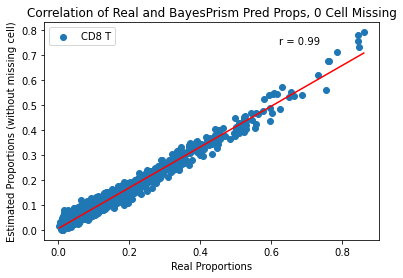

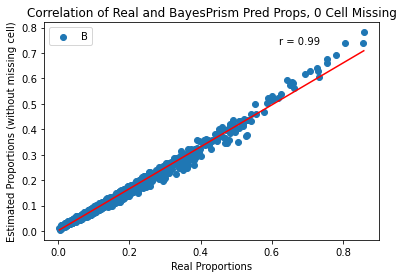

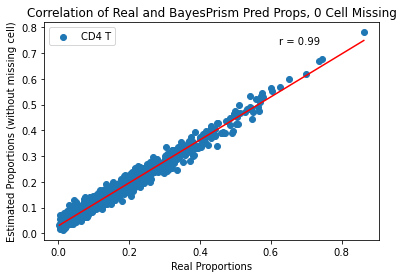

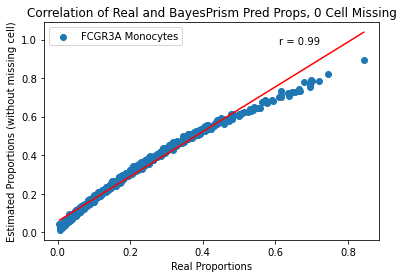

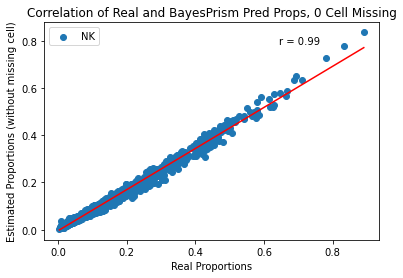

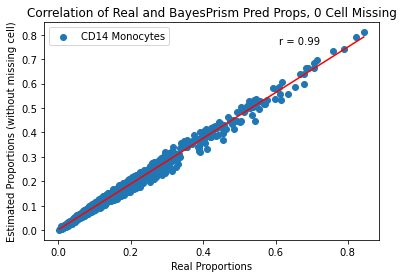

In [ ]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in real_prop[num].columns:
    x = real_prop[num][col_cell].values.astype(float)
    y = cibersort_prop[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and BayesPrism Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 6)
Estimated Proportions shape: (1000, 6)


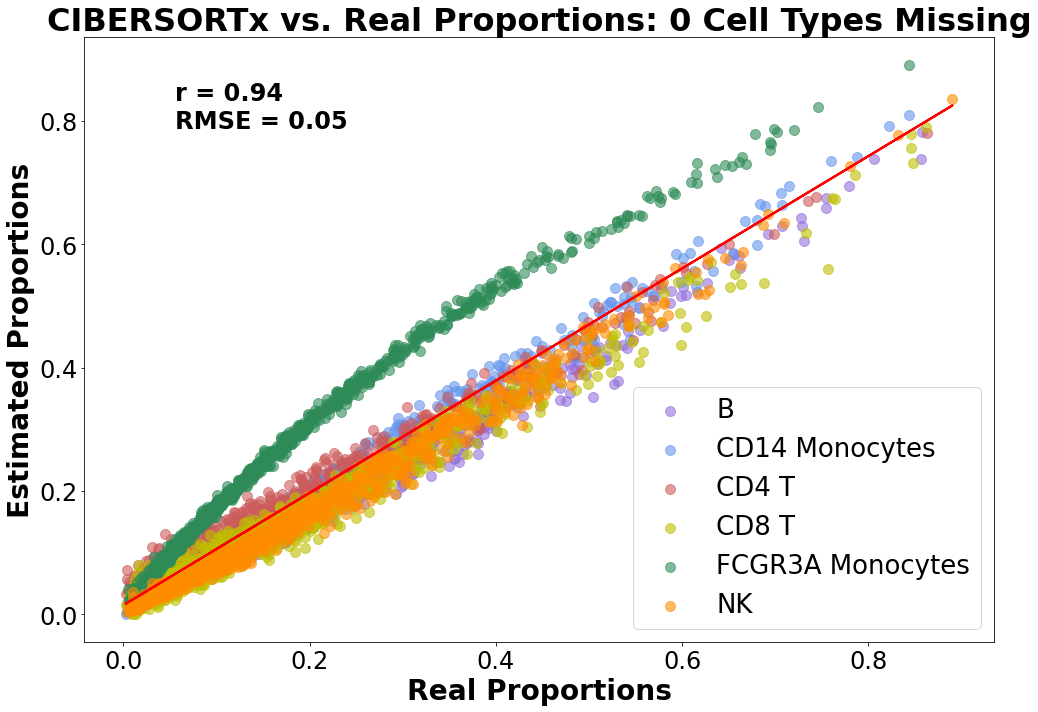

Real Proportions shape: (1000, 5)
Estimated Proportions shape: (1000, 5)


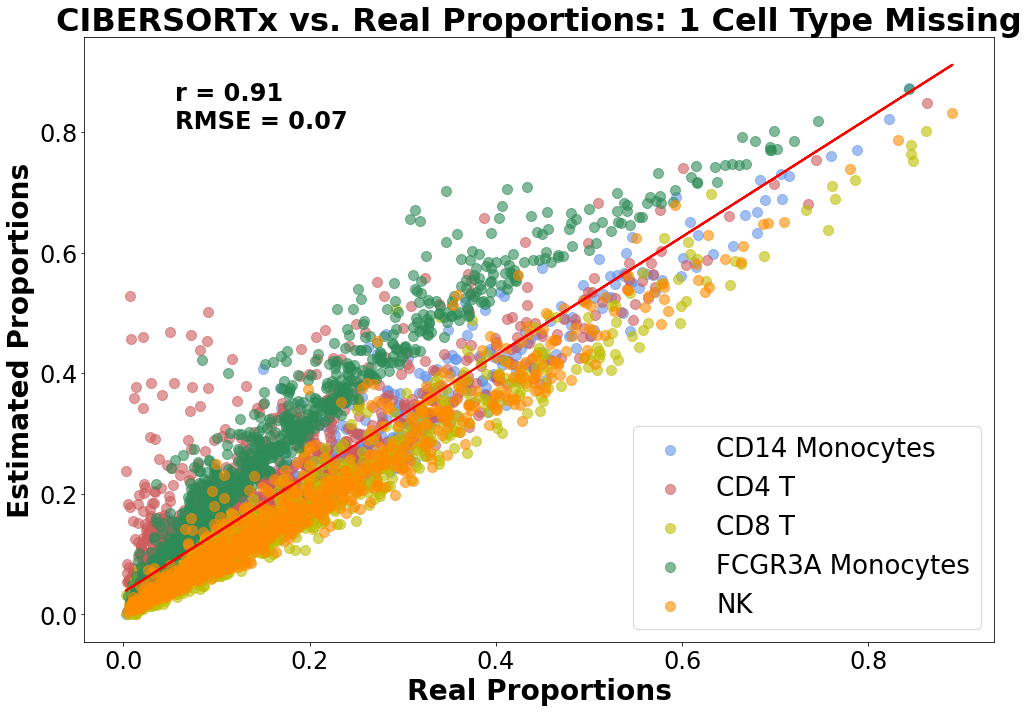

Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


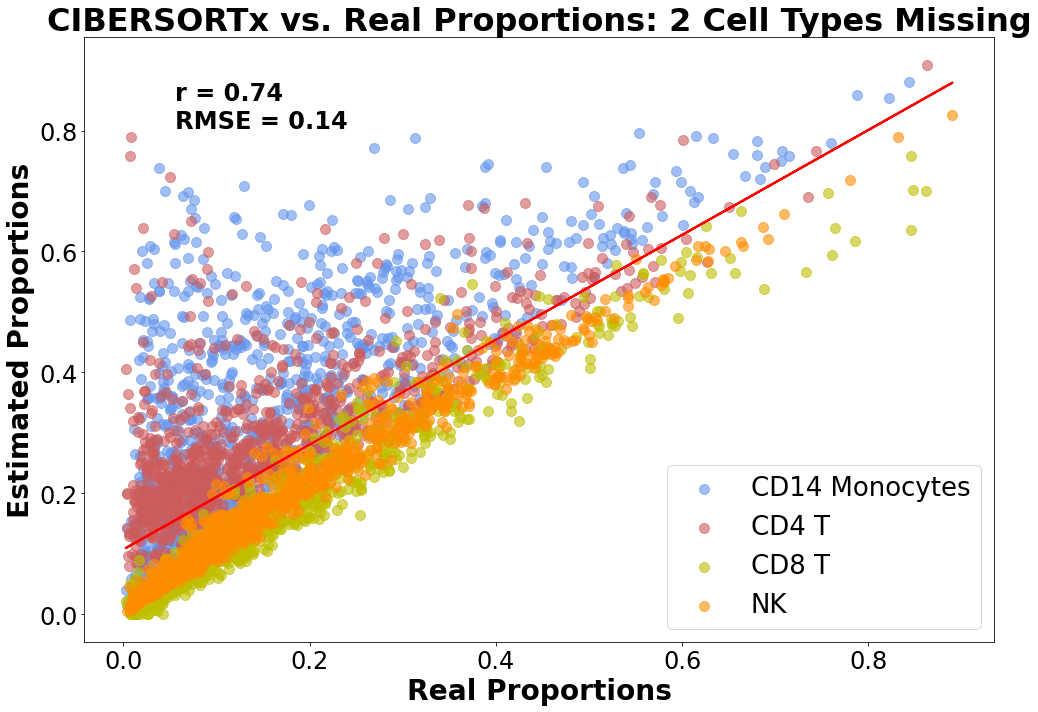

Real Proportions shape: (1000, 3)
Estimated Proportions shape: (1000, 3)


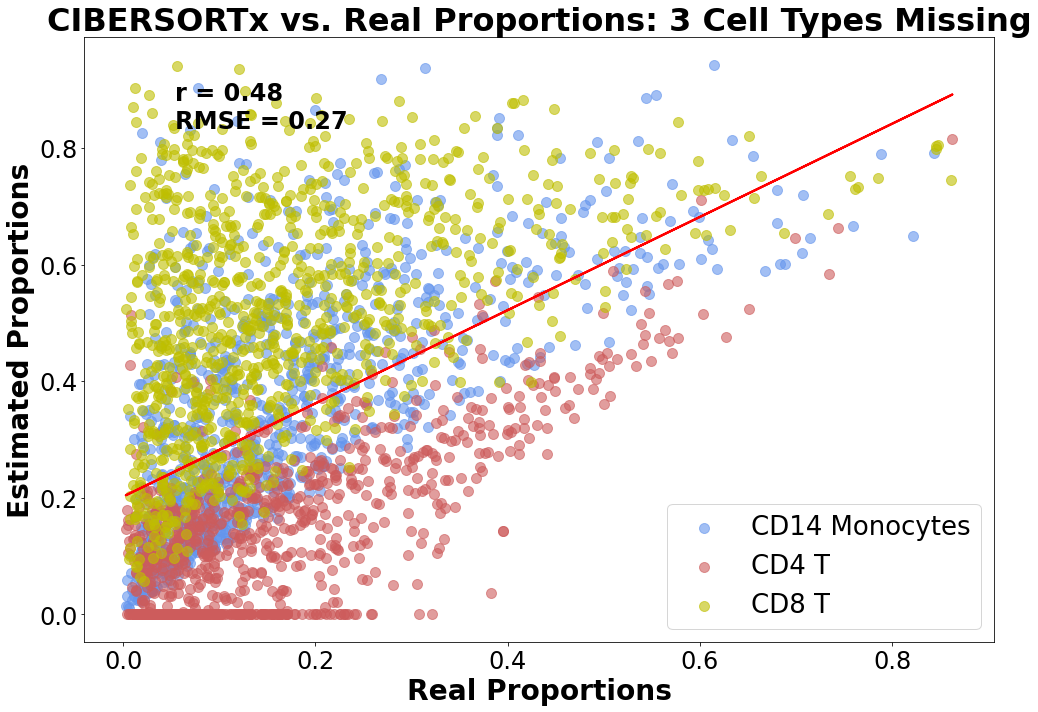

Real Proportions shape: (1000, 2)
Estimated Proportions shape: (1000, 2)


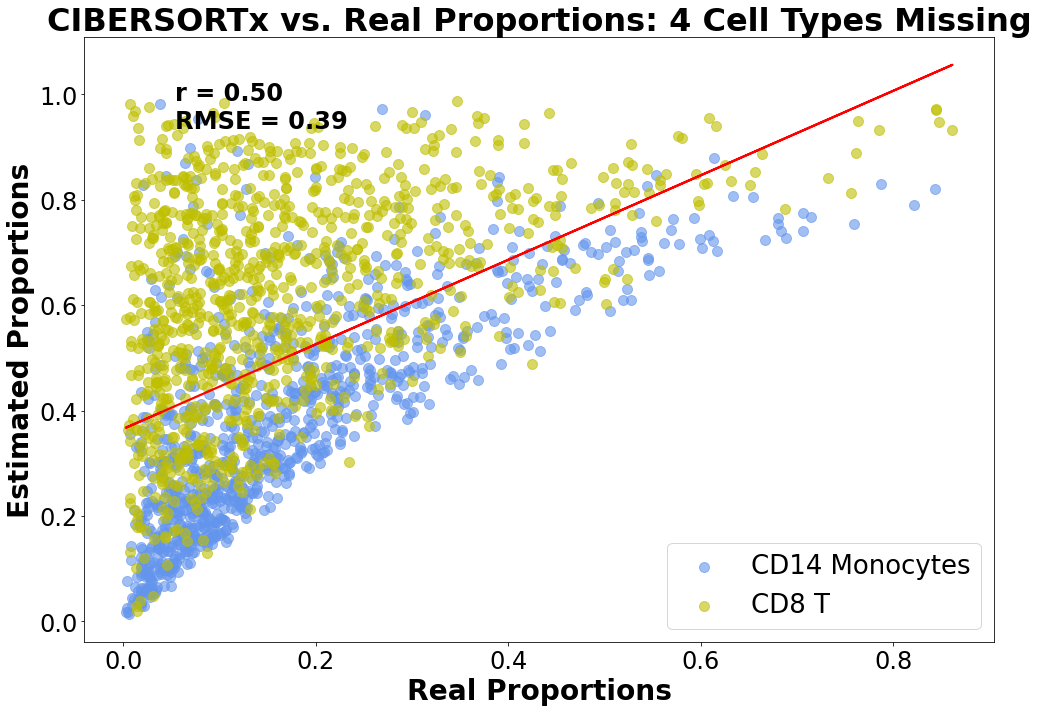

In [ ]:
# Define the custom font properties
font = {'family': 'Arial', 'weight': 'bold'}

# Custom colors for cell types
custom_colors = ['mediumpurple', 'cornflowerblue', 'indianred', 'y', 'seagreen', 'darkorange']

# Collecting all unique cell types across num_missing_cells
all_cell_types = set()
for num in num_missing_cells:
    all_cell_types.update(real_prop_reb[num].columns.tolist())
all_cell_types = sorted(all_cell_types)
# Creating a fixed color mapping for all cell types
color_map = {cell_type: custom_colors[i % len(custom_colors)] for i, cell_type in enumerate(all_cell_types)}

# Loop through each `num_missing_cells` to plot the scatter plots
for num in num_missing_cells:
    
    real_proportions = real_prop_reb[num].values.astype(float)
    estimated_proportions = cibersort_prop[num].values.astype(float)
    cell_types = real_prop_reb[num].columns.tolist()

    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    
    # Scatter plot
    fig, ax = plt.subplots(figsize=(24, 20))  # Increase the figure size for better readability
    for cell_type in cell_types:
        x = real_proportions[:, cell_types.index(cell_type)]
        y = estimated_proportions[:, cell_types.index(cell_type)]
        
        # Use the fixed color mapping for consistent coloring
        color = color_map[cell_type]
        
        ax.scatter(x, y, label=cell_type, color=color, alpha=0.6, s=450)  # Increase marker size for clarity
    
    # Fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red", linewidth=2.2)  # Make the regression line thicker
    
    # Calculate r and RMSE
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    rmse = np.sqrt(((real_proportions - estimated_proportions) ** 2).mean())
    
    # Annotate with r and RMSE
    plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.1, 0.85), xycoords='axes fraction', fontsize=38, weight='bold')
    
    # Set axis labels and title with increased font size
    plt.xlabel('Real Proportions', fontsize=38, fontweight='bold')
    plt.ylabel('Estimated Proportions', fontsize=38, fontweight='bold')
    if num == 1:
        plt.title(f'CIBERSORTx vs. Real Proportions: {num} Cell Type Missing', fontsize=49, fontweight='bold')
    else:    
        plt.title(f'CIBERSORTx vs. Real Proportions: {num} Cell Types Missing', fontsize=49, fontweight='bold')

    # Increase legend font size
    plt.legend(loc='lower right', fontsize=42)  # Show the cell type labels in the legend

    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=34)  # Adjust the tick label size

    # Show the plot
    plt.tight_layout()
    plt.show()

Real Proportions shape: (1000, 6)
Estimated Proportions shape: (1000, 6)


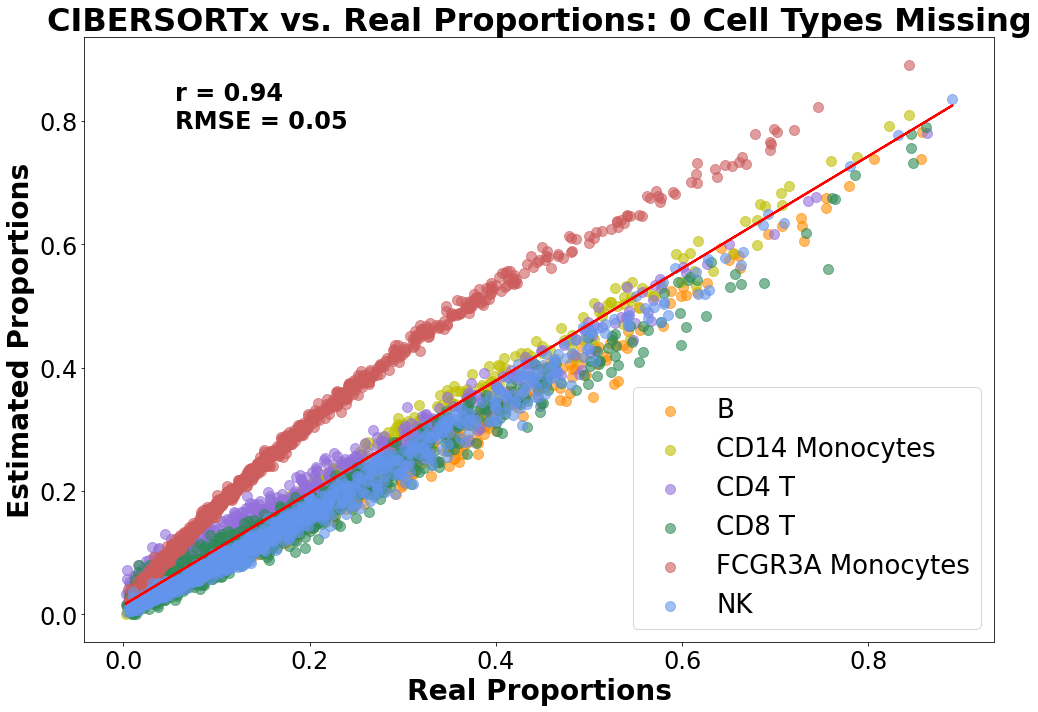

Real Proportions shape: (1000, 5)
Estimated Proportions shape: (1000, 5)


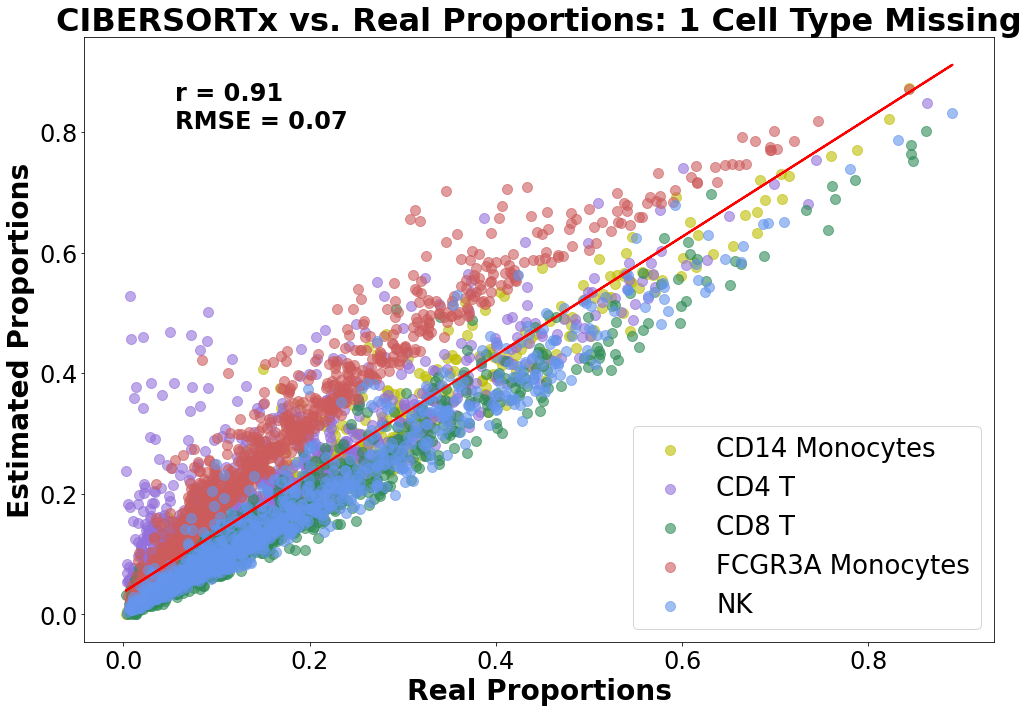

Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


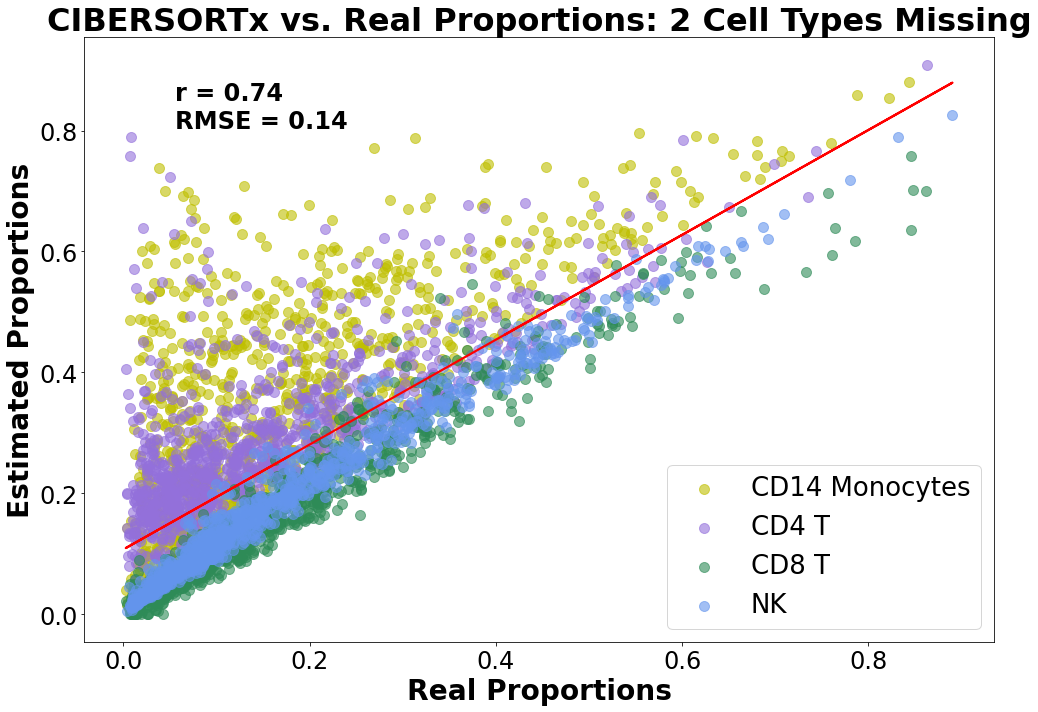

Real Proportions shape: (1000, 3)
Estimated Proportions shape: (1000, 3)


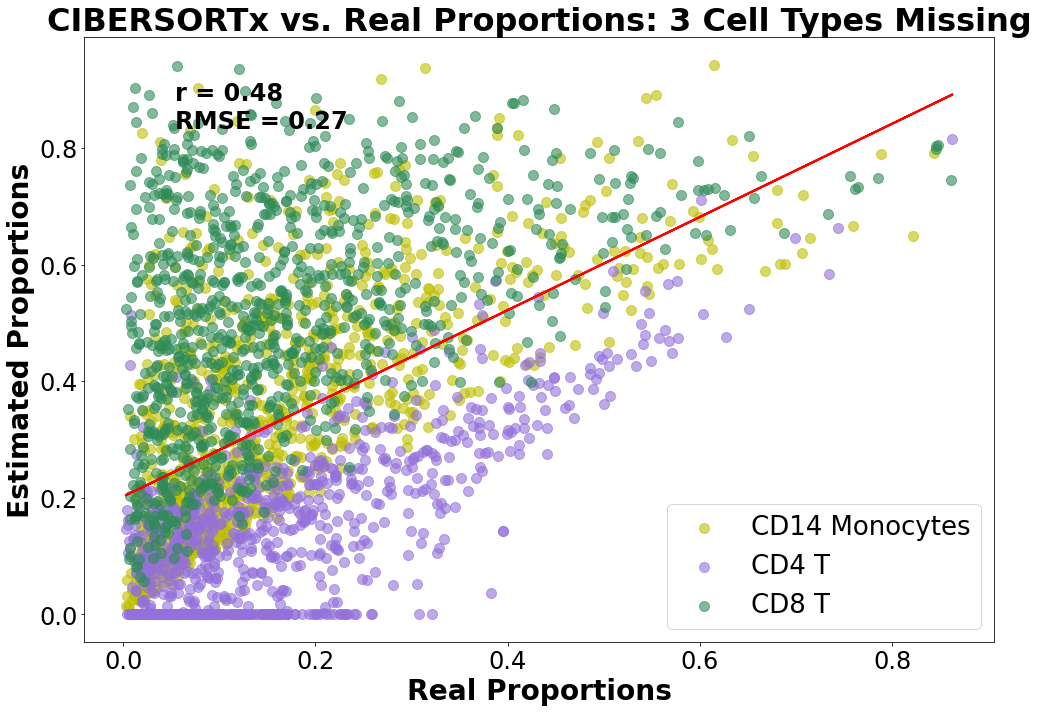

Real Proportions shape: (1000, 2)
Estimated Proportions shape: (1000, 2)


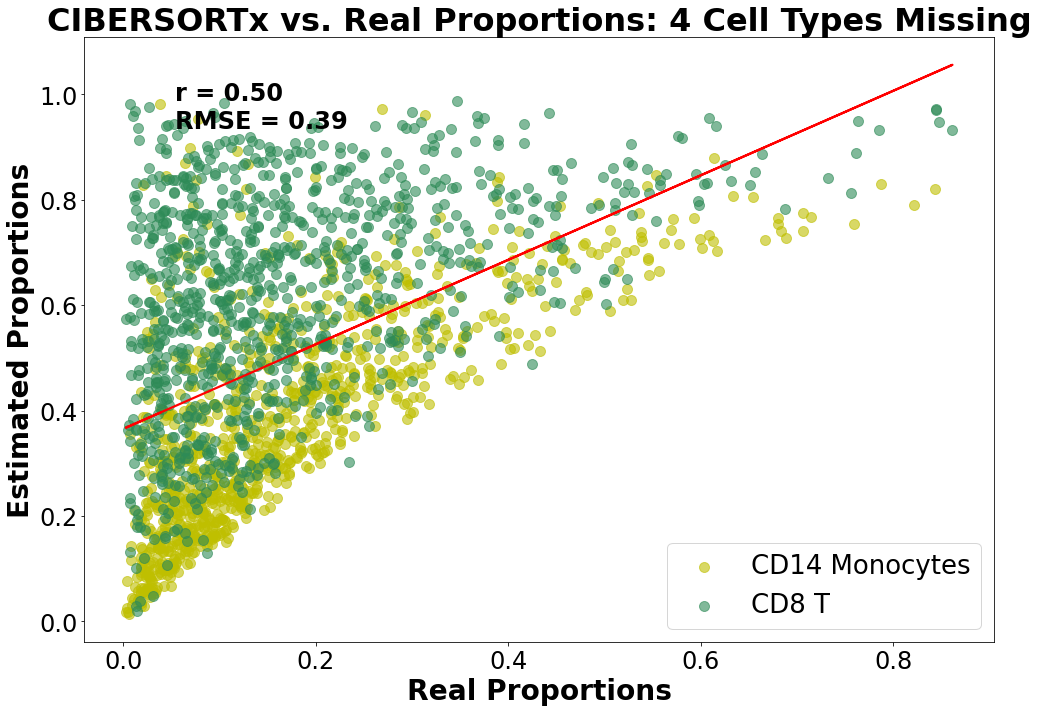

In [ ]:
# Define the custom font properties
font = {'family': 'Arial', 'weight': 'bold', 'size': 22}

# Custom colors for cell types
custom_colors = ['mediumpurple', 'cornflowerblue', 'indianred', 'y', 'seagreen', 'darkorange']

# Collecting all unique cell types across num_missing_cells
all_cell_types = set()
for num in num_missing_cells:
    all_cell_types.update(real_prop_reb[num].columns.tolist())

# Creating a fixed color mapping for all cell types
color_map = {cell_type: custom_colors[i % len(custom_colors)] for i, cell_type in enumerate(all_cell_types)}

for num in num_missing_cells:
    
    real_proportions = real_prop_reb[num].values.astype(float) #real proportions of present cells
    estimated_proportions = cibersort_prop[num].values.astype(float) #estimated proportions of present cells.
    cell_types = real_prop_reb[num].columns.tolist() 

    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    
    # Scatter plot
    fig, ax = plt.subplots(figsize=(14, 10))  # Increase the figure size for better readability
    for cell_type in cell_types:
        x = real_proportions[:, cell_types.index(cell_type)]
        y = estimated_proportions[:, cell_types.index(cell_type)]
        
        # Use the fixed color mapping
        color = color_map[cell_type]
        
        ax.scatter(x, y, label=cell_type, color=color, alpha=0.6, s=100)  # Increase marker size for clarity
    
    # Fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red", linewidth=2.2)  # Make the regression line thicker
    
    # Calculate r and RMSE
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    rmse = np.sqrt(((real_proportions - estimated_proportions) ** 2).mean())
    
    # Annotate with r and RMSE
    plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.1, 0.85), xycoords='axes fraction', fontsize=24, weight='bold')
    
    # Set axis labels and title with increased font size
    plt.xlabel('Real Proportions', fontsize=28, fontweight='bold')
    plt.ylabel('Estimated Proportions', fontsize=28, fontweight='bold')
    if num == 1:
        plt.title(f'CIBERSORTx vs. Real Proportions: {num} Cell Type Missing', fontsize=32, fontweight='bold')
    else:    
        plt.title(f'CIBERSORTx vs. Real Proportions: {num} Cell Types Missing', fontsize=32, fontweight='bold')

    # Increase legend font size
    plt.legend(loc='lower right', fontsize=26)  # Show the cell type labels in the legend

    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=24)  # Adjust the tick label size

    # Show the plot
    plt.tight_layout()
    plt.show()


And save results:

In [ ]:
# Iterate through num_missing_cells
real_df = pd.DataFrame()
predicted_df = pd.DataFrame()

for num in num_missing_cells:
    real_proportions = real_prop_reb[num].values.astype(float)
    estimated_proportions = cibersort_prop[num].values.astype(float)
    cell_types = real_prop_reb[num].columns.tolist()

    # Create dataframes
    real_df_current = pd.DataFrame(data=real_proportions, columns=cell_types, index=[num]*len(real_proportions))
    predicted_df_current = pd.DataFrame(data=estimated_proportions, columns=cell_types, index=[num]*len(estimated_proportions))

    real_df = pd.concat([real_df, real_df_current])
    predicted_df = pd.concat([predicted_df, predicted_df_current])


# Save dataframes to .txt files
real_filename = f"{path_results}EXP2_cibersortx_pbmc_real.txt"
predicted_filename = f"{path_results}EXP2_cibersortx_pbmc_predicted.txt"

# Save dataframes to .txt files
with open(real_filename, 'w') as file:
    real_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

with open(predicted_filename, 'w') as file:
    predicted_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

Compare Error: Real Proportions - Estimated Proportions 

In [ ]:
#the difference between calculated and real proportions.
custom_res_tot = dict()
for num in num_missing_cells:
    custom_res_tot[num] = real_prop[num].values - cibersort_prop[num]

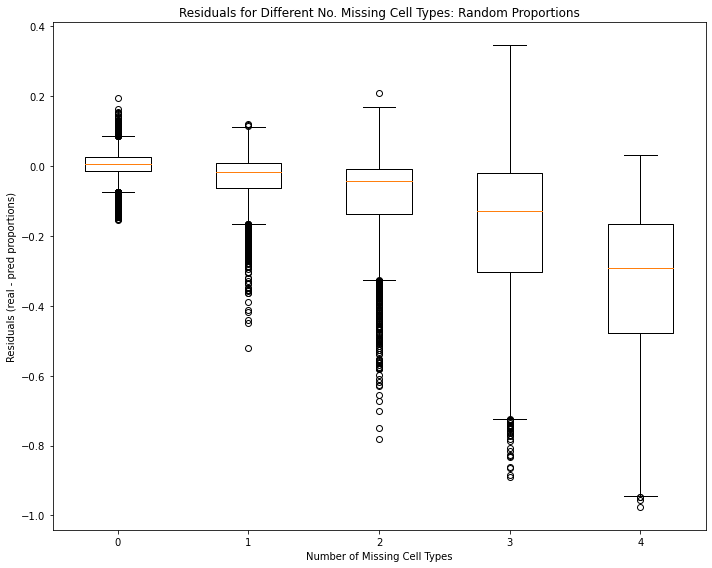

In [ ]:
#Distribution of residuals as the difference between calculated and real proportions.
#the difference between calculated and real proportions.
custom_res_tot = dict()
for num in num_missing_cells:
    custom_res_tot[num] = real_prop[num].values - cibersort_prop[num]
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

## **Extracting Missing Cell Information:**

In [ ]:
cells_to_miss = dict()
missing_cell_tot  = dict()
for num in num_missing_cells:
    #cells that are missing
    cells_to_miss[num] = np.setdiff1d(ref_df[0].columns, ref_cibersort[num].columns)
    #extracting real proportions from missing cells
    missing_cell_tot[num] = real_prop[0][cells_to_miss[num]]
    print(f"{num} missing: {missing_cell_tot[num].shape}")

0 missing: (1000, 0)
1 missing: (1000, 1)
2 missing: (1000, 2)
3 missing: (1000, 3)
4 missing: (1000, 4)


In [ ]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = real_prop[0][missing_cell_tot[num].columns]  
    print(f"{num} missing: prop is {missing_cell_prop[num].shape}")

1 missing: prop is (1000, 1)
2 missing: prop is (1000, 2)
3 missing: prop is (1000, 3)
4 missing: prop is (1000, 4)


## **Calculate Residuals:**

Residual uses:

Pseudobulks - [Calculated_Proportions * Reference]

In [ ]:
#Residual: pseudobulks as used, minus reference of ciberef_cibersort * calculated proportions
residuals = dict()
for num in num_missing_cells:
    res = (pseudo_df[num].values) - (cibersort_prop[num] @ ref_df[num].T)
    residuals[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals[3]    

gene_ids AL627309.1 AP006222.2 RP11-206L10.2 RP11-206L10.9  LINC00115  \
0         18.979826   7.991635           6.0      6.994639  33.986973   
1          7.985578   1.990952           3.0      3.997771  41.990561   
2         19.976186   7.992839      2.999905     10.992385  50.983679   
3         30.974717   7.992242           2.0     13.991857  32.983786   
4          8.983231  -0.007768      2.999877      7.996141  54.987768   
..              ...        ...           ...           ...        ...   
995       22.970662   3.992724           4.0     13.989649  53.981257   
996        8.985418   3.995416      4.999453      5.996119  36.984565   
997        8.985105   8.992786      3.999781      8.996888  36.987908   
998        6.981517   2.991434          12.0       6.99556  38.988028   
999       17.981636   4.993144      3.999788      9.995018  44.985815   

gene_ids       NOC2L     KLHL17    PLEKHN1 RP11-54O7.17         HES4  ...  \
0          581.76826  11.997953  14.991387    14.995614   922.913162  ...   
1         700.756188  18.999149  15.992241    10.998176   981.960026  ...   
2         577.776972   7.996332  22.990416     12.99377   1046.87884  ...   
3         590.778985  18.996891  18.990628     8.993337  1080.871525  ...   
4         647.762504   12.99754  12.991334     1.996842   599.934857  ...   
..               ...        ...        ...          ...          ...  ...   
995       612.787496  18.996048   7.990026    11.991531  1756.838485  ...   
996       601.762691   17.99414   7.989739     6.996825  1024.931892  ...   
997       577.759647  15.997061  14.991179     2.997454   423.945443  ...   
998       650.764711  19.998305  11.991638     2.996367   816.926939  ...   
999       528.766854    15.9964  23.990694     5.995924   295.917499  ...   

gene_ids     MT-ND4L   MT-ND4  MT-ND5      MT-ND6   MT-CYB AC145212.1  \
0         801.602656  26433.0  4812.0  551.704864  23068.0  33.979201   
1         880.611824  24703.0  4465.0  507.678613  20934.0  22.986091   
2         780.589692  25359.0  4772.0   538.72751  21417.0  43.974385   
3         851.594511  24708.0  4790.0  531.728186  21916.0   33.97308   
4          820.59879  22966.0  3997.0   499.69715  19231.0  32.982689   
..               ...      ...     ...         ...      ...        ...   
995       821.588048  26166.0  5127.0  504.746694  22173.0  51.968222   
996       868.570324  27032.0  4867.0  525.714072  22345.0  38.983279   
997       818.594575  24435.0  4198.0  536.694661  21358.0  29.984477   
998       797.605352  24563.0  3829.0  401.697146  19330.0  28.981227   
999       892.589545  21364.0  3823.0  504.710075  18577.0  26.980352   

gene_ids  AL592183.1 AL354822.1     PNRC2-1    SRSF10-1  
0         627.728991  28.998246  197.884825  121.961335  
1         698.723924  27.999271  216.866546  142.948181  
2         576.723588  27.996938  221.899429  133.968616  
3         620.733494  18.997335  187.901064  108.973021  
4         678.714818  15.997997  189.877942  104.952193  
..               ...        ...         ...         ...  
995       613.737067  35.996612  190.913951  136.982295  
996       702.674472  25.995447  242.884531  177.942531  
997       660.704505  11.997668  197.875038  112.946856  
998       789.727502  22.998547  182.879451  124.957468  
999       619.708164   7.997096  141.885852   58.954864  

[1000 rows x 13714 columns]

In [ ]:
#scaling the residual and references
ref_df_scaled = dict()
pseudo_scaled = dict()
for num in num_missing_cells:
    #clippign before scaling to 95th pecentile
    ref_raw_val = ref_df[num].values ##reference created
    clip_upper = np.quantile(ref_raw_val, 0.90)
    ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(ref_raw_val)
    ref_scale = scaler.transform(ref_raw_val)
    ref_df_scaled[num] = pd.DataFrame(ref_scale, index = ref_df[num].index, columns = real_prop[num].columns)
    print(ref_df_scaled[num].shape)
    #clippign before scaling to 95th pecentile
    pseudo_raw_val = pseudo_df[num][ref_df[num].index].values ##pseudobulks
    clip_upper = np.quantile(pseudo_raw_val, 0.90)
    pseudo_raw_val = np.clip(pseudo_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    pseudo_scaled[num] = pd.DataFrame(pseudo_scale, columns = gene_ids[num])
    print(pseudo_df[num].shape)

(13714, 6)
(1000, 13714)
(13714, 5)
(1000, 13714)
(13714, 4)
(1000, 13714)
(13714, 3)
(1000, 13714)
(13714, 2)
(1000, 13714)


In [ ]:
# QC of scaling
print(ref_cibersort[1].max().max())
print(ref_df_scaled[1].max().max())

print(pseudo_df[1].max().max())
print(pseudo_scaled[1].max().max())

21983.1373328142
1.0
581671.0
1.0000000000000018


In [ ]:
#Residual with the scaled pseudobulk and scaled reference.
residuals_scaled = dict()
for num in num_missing_cells:
    res = (pseudo_scaled[num].values)  - (cibersort_prop[num] @ ref_df_scaled[num].T)
    residuals_scaled[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals_scaled[0]    

gene_ids  AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  LINC00115  \
0           0.271673    0.463158       0.211773       0.220516   0.346462   
1           0.106344    0.114157       0.104172       0.123490   0.479855   
2           0.286493    0.465466       0.105045       0.351628   0.639718   
3           0.458322    0.463908       0.070178       0.449556   0.322555   
4           0.114337   -0.003955       0.103562       0.256883   0.706502   
..               ...         ...            ...            ...        ...   
995         0.333232    0.230620       0.140809       0.445598   0.687573   
996         0.118997    0.231638       0.176285       0.189057   0.399281   
997         0.112285    0.522474       0.139969       0.292294   0.401343   
998         0.090759    0.174399       0.417492       0.224138   0.427561   
999         0.245496    0.288259       0.141277       0.321307   0.529715   

gene_ids     NOC2L    KLHL17   PLEKHN1  RP11-54O7.17      HES4  ...   MT-ND4L  \
0        -0.195674  0.273927  0.442138      0.503820  0.545655  ... -0.449410   
1        -0.020664  0.452109  0.470131      0.368015  0.625511  ... -0.214448   
2        -0.217236  0.165370  0.682896      0.432804  0.555905  ... -0.549767   
3        -0.187329  0.455662  0.560977      0.293259  0.532049  ... -0.301068   
4        -0.091575  0.294581  0.375434      0.059077  0.299083  ... -0.405168   
..             ...       ...       ...           ...       ...  ...       ...   
995      -0.189011  0.453508  0.232623      0.391750  0.365298  ... -0.423623   
996      -0.155456  0.428521  0.229691      0.229018  0.600900  ... -0.261487   
997      -0.168152  0.379133  0.437856      0.095660  0.166445  ... -0.385998   
998      -0.095131  0.480065  0.355451      0.093185  0.482576  ... -0.439827   
999      -0.301102  0.374610  0.703259      0.196463  0.017622  ... -0.156773   

gene_ids  MT-ND4  MT-ND5    MT-ND6  MT-CYB  AC145212.1  AL592183.1  \
0           -1.0    -1.0  0.042174    -1.0    0.360915   -0.337855   
1           -1.0    -1.0 -0.076089    -1.0    0.228293   -0.196014   
2           -1.0    -1.0  0.024305    -1.0    0.487249   -0.501903   
3           -1.0    -1.0  0.009059    -1.0    0.353184   -0.342929   
4           -1.0    -1.0 -0.060956    -1.0    0.357123   -0.249837   
..           ...     ...       ...     ...         ...         ...   
995         -1.0    -1.0 -0.055943    -1.0    0.578787   -0.376710   
996         -1.0    -1.0 -0.042376    -1.0    0.430976   -0.173748   
997         -1.0    -1.0  0.003548    -1.0    0.319768   -0.270135   
998         -1.0    -1.0 -0.256266    -1.0    0.301011    0.007228   
999         -1.0    -1.0 -0.031250    -1.0    0.274241   -0.376180   

gene_ids  AL354822.1   PNRC2-1  SRSF10-1  
0           0.411309  0.250226  0.296645  
1           0.393437  0.370946  0.376006  
2           0.392637  0.405396  0.349764  
3           0.256634  0.217375  0.261734  
4           0.220429  0.233793  0.249897  
..               ...       ...       ...  
995         0.500726  0.237432  0.348781  
996         0.358232  0.496073  0.500565  
997         0.162527  0.245301  0.271553  
998         0.313099  0.194655  0.294968  
999         0.110616 -0.026861  0.100883  

[1000 rows x 13714 columns]

## NMF 

Analyzing how close to negative the distributions of each residual are:

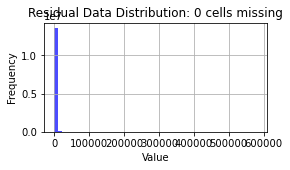

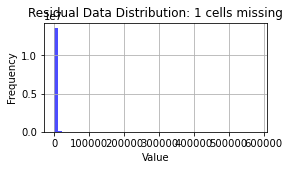

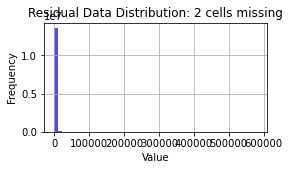

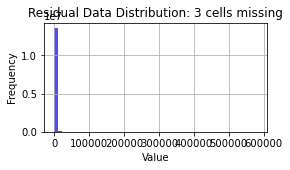

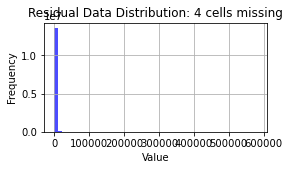

In [ ]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

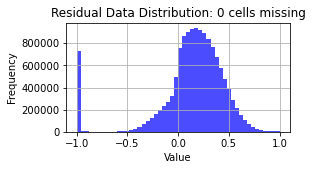

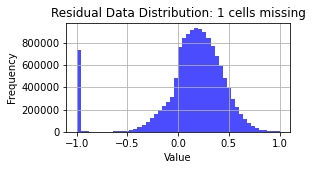

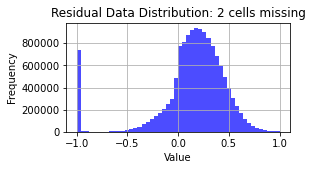

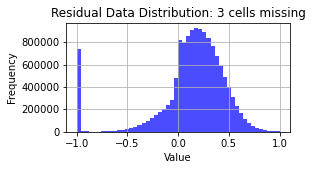

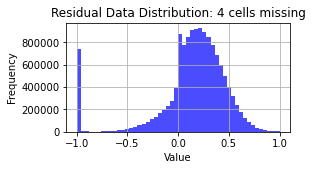

In [ ]:
#distribution of residuals, but scaled
for num in num_missing_cells:
    data = residuals_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.05581313023859064


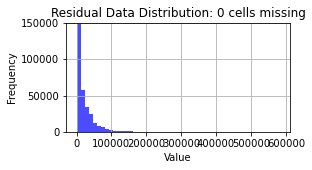

0.07478507783919269


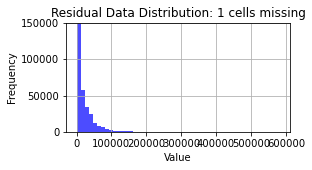

0.11007589114330225


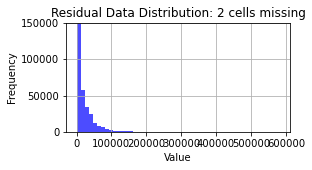

0.1938248053719166


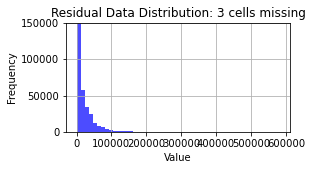

0.20561082813392248


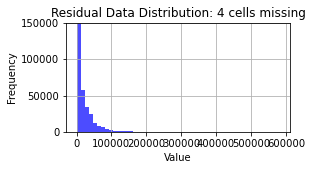

In [ ]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals.copy()
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.ylim(0,150000)
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9999999403953571


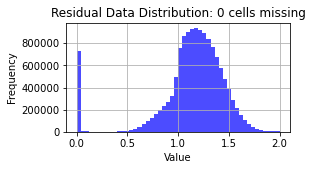

1.0000000000000018


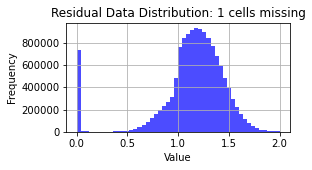

1.0000000000000013


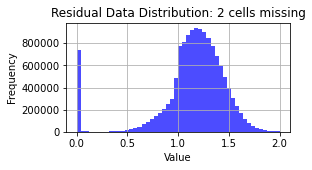

0.9999999403953563


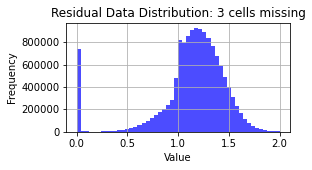

1.0000000000000009


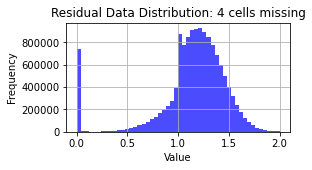

In [ ]:
#shift_scaleding distribution of residuals to do NMF
residuals_shift_scaled = residuals_scaled
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift_scaled distributions minimally:
        min_val = abs(np.min(np.min(residuals_scaled[num])))
        print(min_val)
        residuals_shift_scaled[num] = residuals_scaled[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift_scaled[num][residuals_shift_scaled[num].values <= 0] = 0
    data = residuals_shift_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Now comparing the Residual Scaled (with pseudobulks and reference MinMax scaled) and the Residual (not scaled, all matrices as used in deconvolution). We can see the impact of scaling in our ability to recover the missing cell type's proportions.

Residual

/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


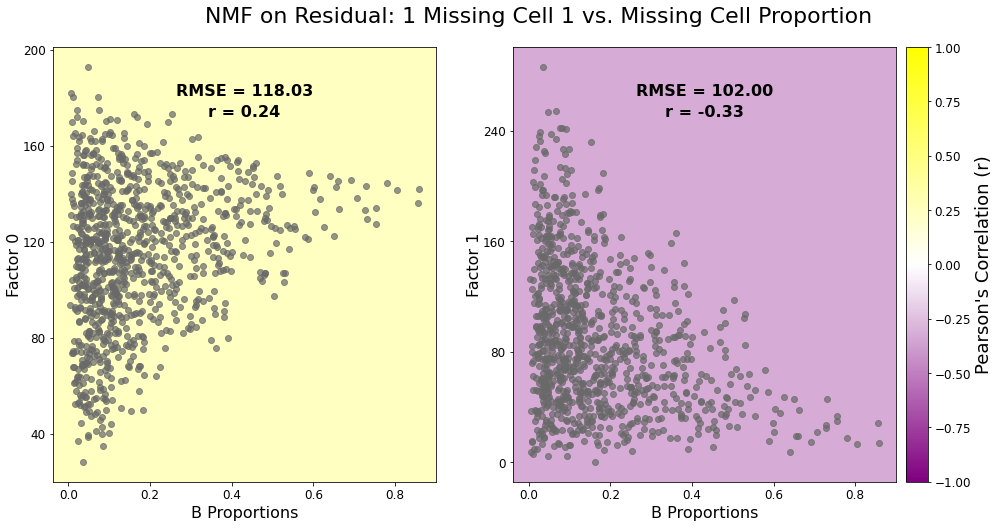

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


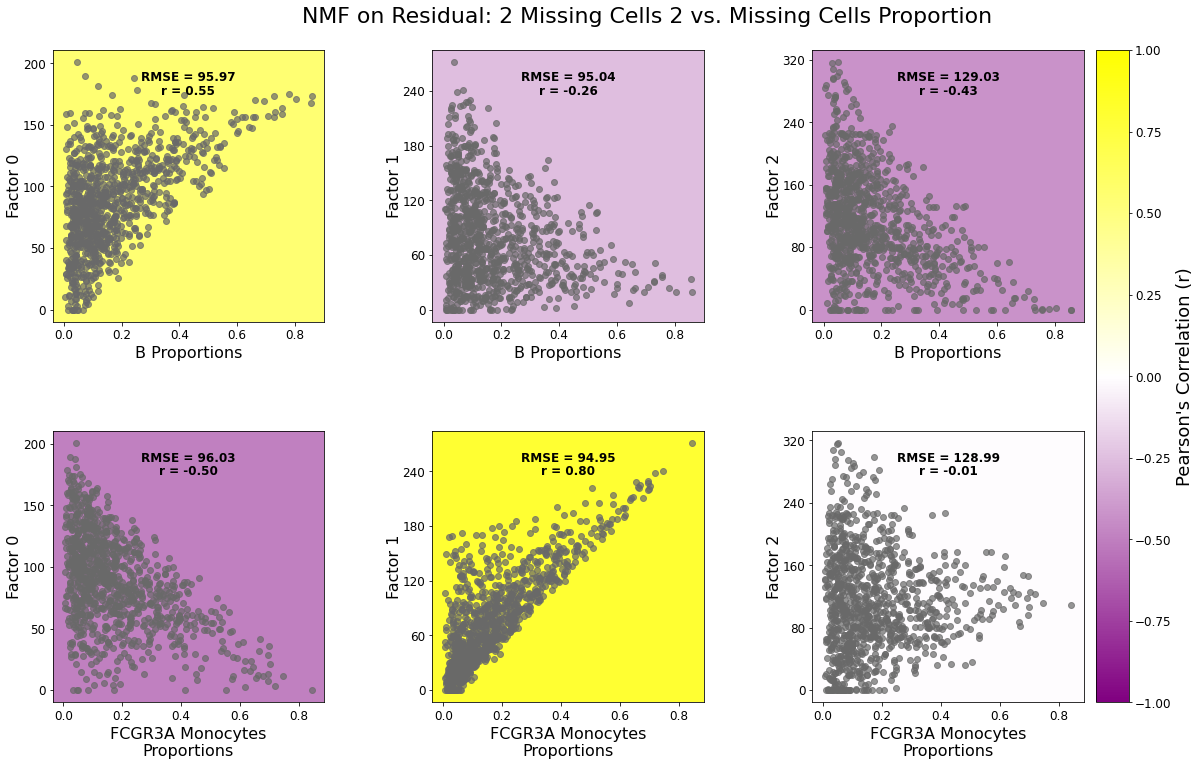

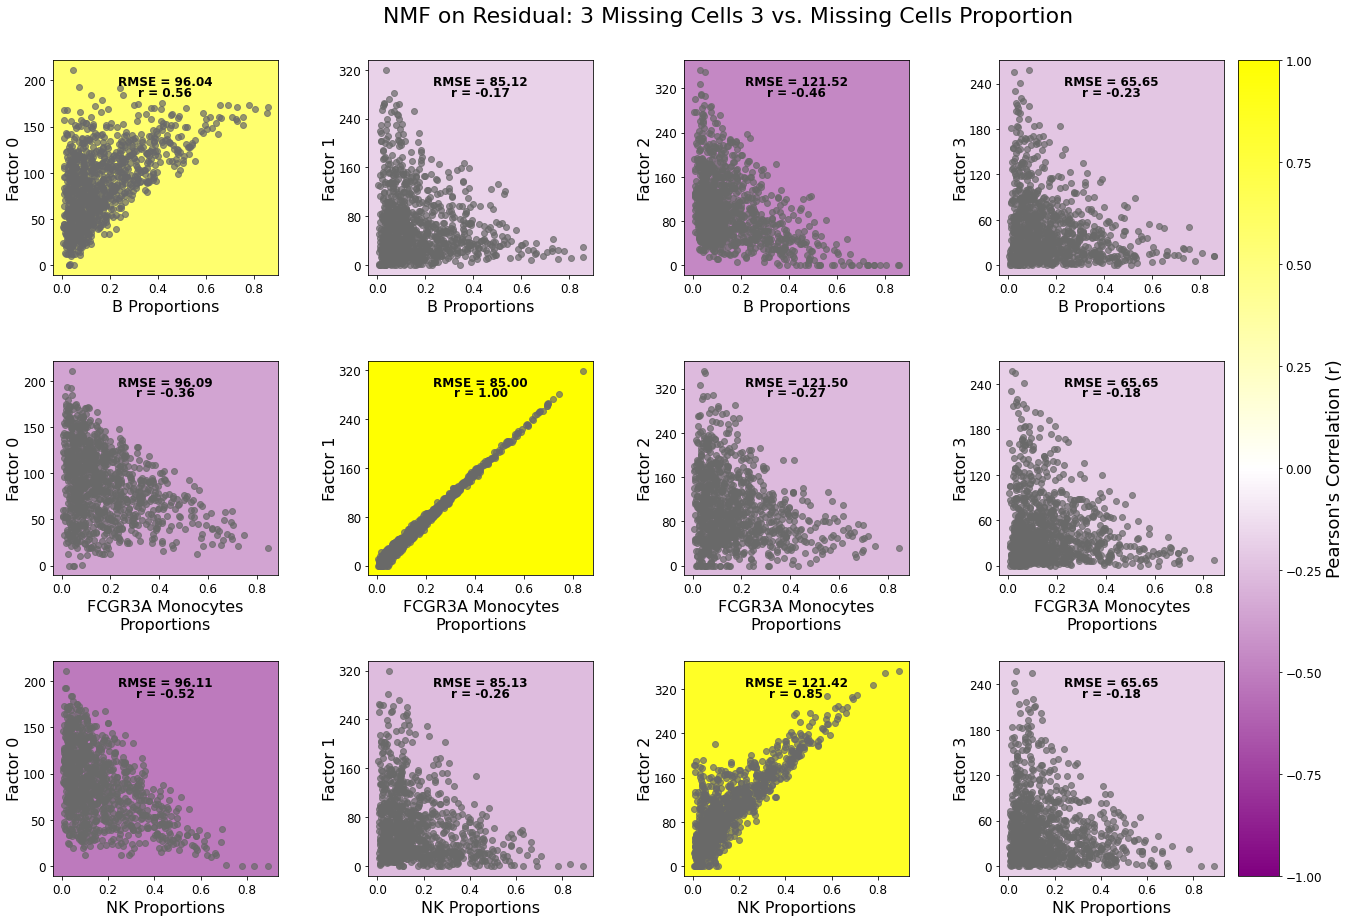

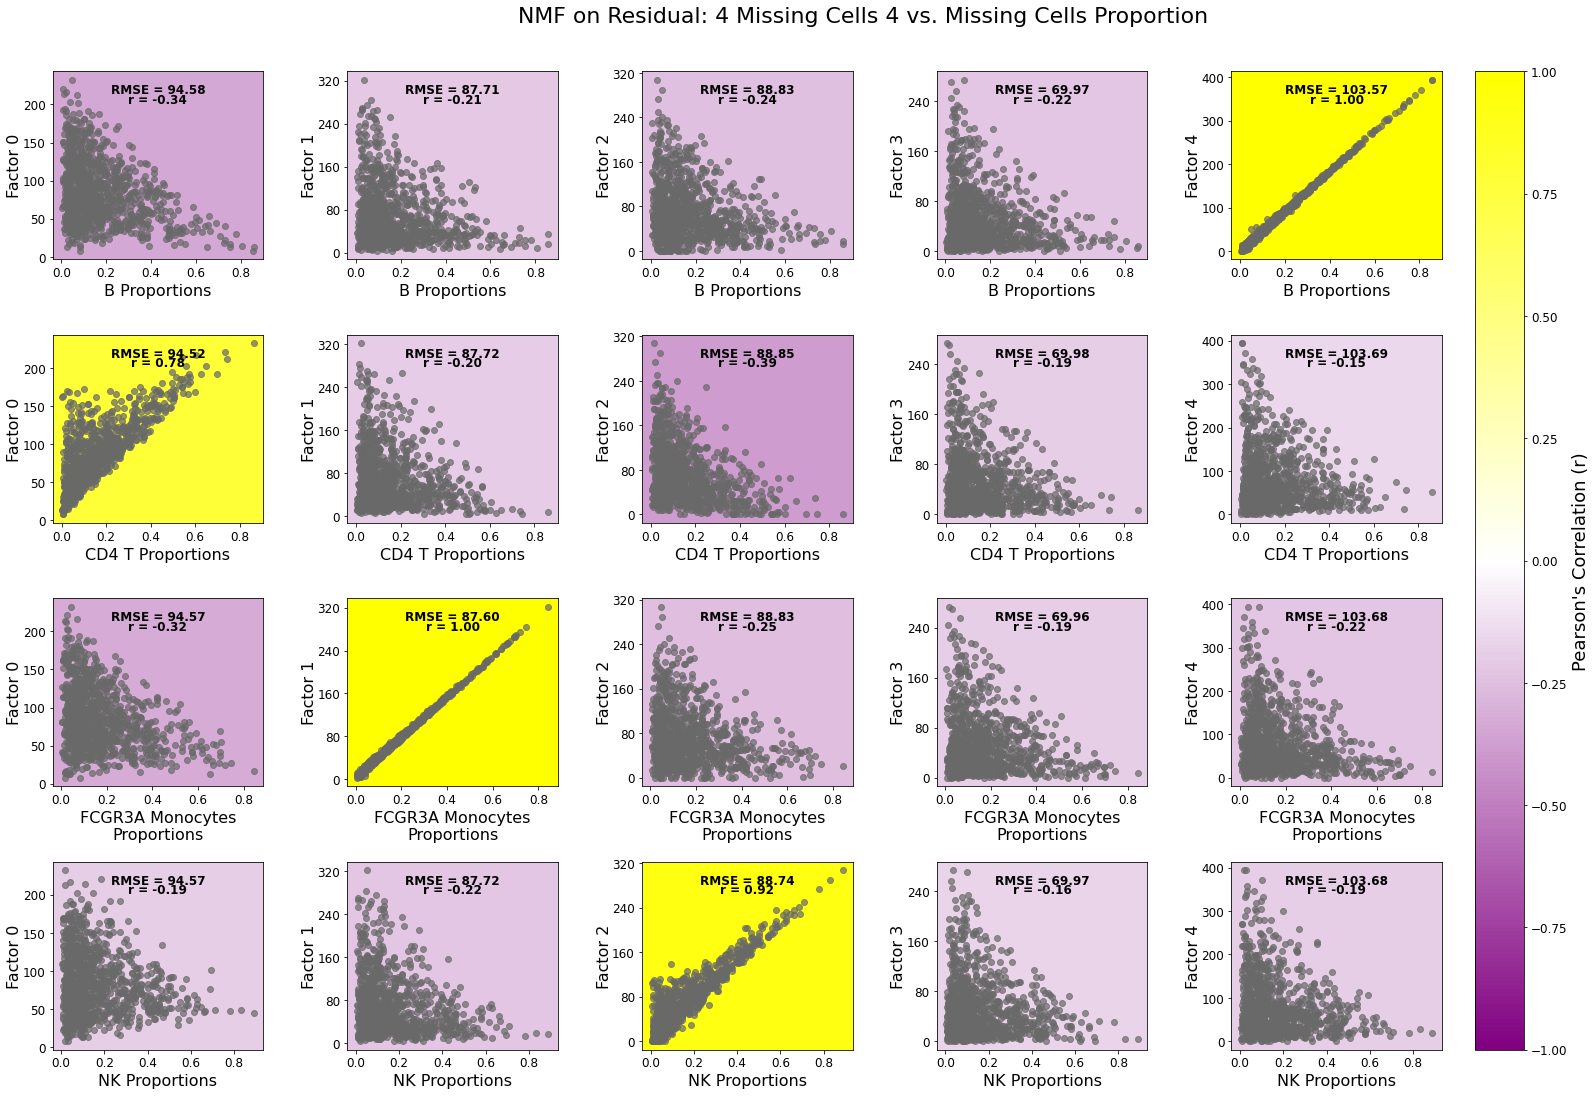

In [ ]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter=10000, init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

Residual_scaled (0 to 1)

In [ ]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num + 1
    nmf = NMF(n_components = num_nmf, max_iter=10000, init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
/projects/aivich@xsede.org/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


KeyboardInterrupt: 

Same as above, but now making the NMF components be in the same scale (0 to 1).

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


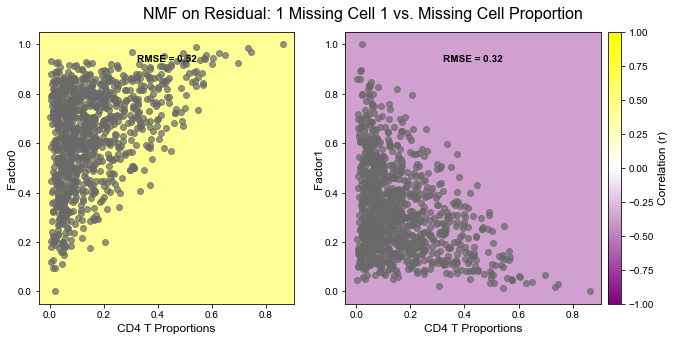

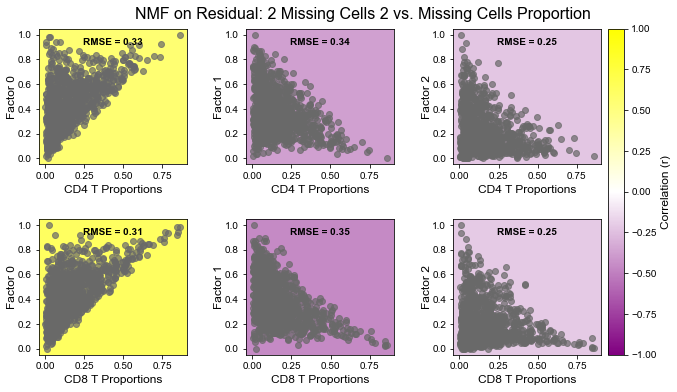

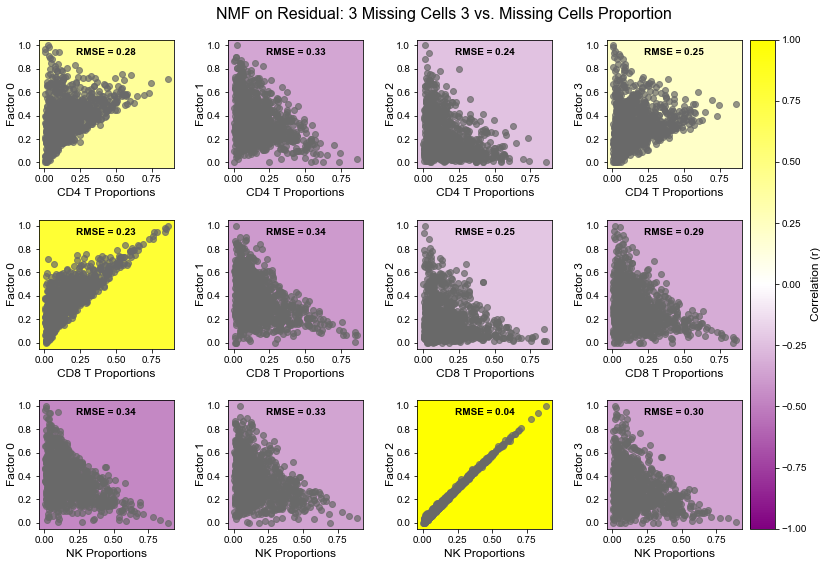

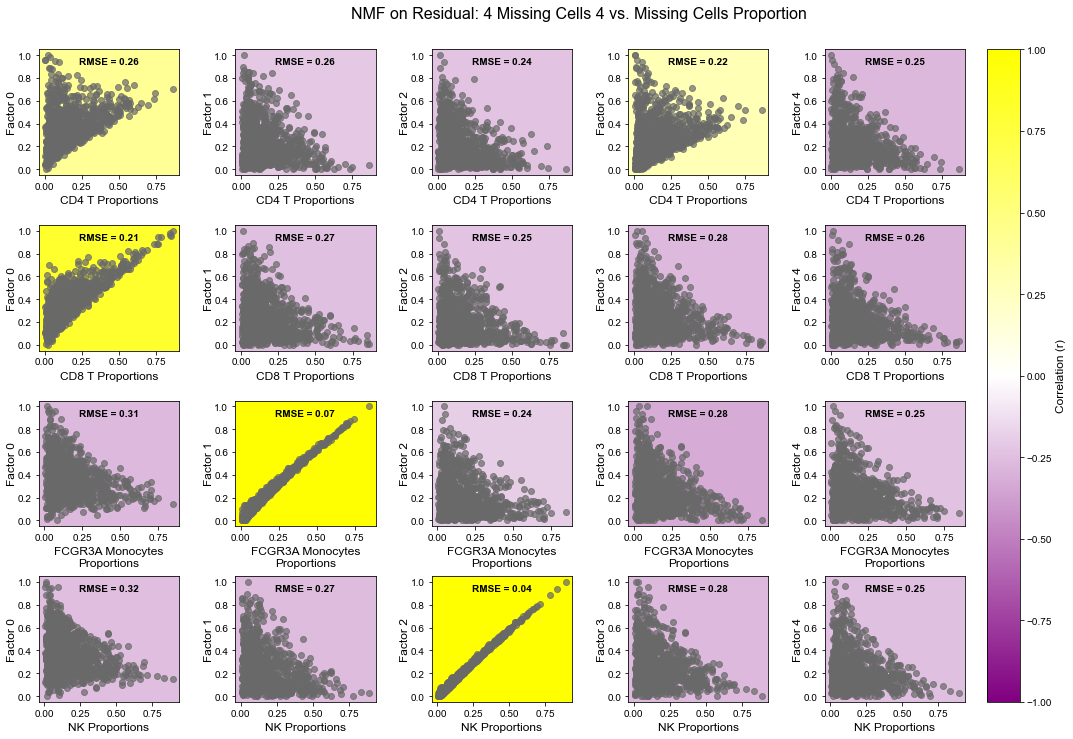

In [ ]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000 ,init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
    #putting each component between 0 and 1 to match proportion range
    pseudo_raw_val = res_nmf_df.values 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    res_nmf[num] = pd.DataFrame(pseudo_scale)
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

For comparison across deconvolution methods, see exploratory_experiments/EXP2_eval.ipynb